A notebook for looking at the results of one run of syn_ahrens_gnlr_mdls

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

from ahrens_wbo.data_processing import generate_torch_dataset
from ahrens_wbo.data_processing import load_and_preprocess_data
from ahrens_wbo.data_processing import SegmentTable
from janelia_core.stats.regression import r_squared
from probabilistic_model_synthesis.gaussian_nonlinear_regression import predict
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()

# Specify the location of results
ps['results_dir'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v18_cp/fold_str_base_14_tgt_1/fold_1/subj_10/comb'
ps['results_file'] = r'test_results.pt'

# Specify if we want to look at sp or ip fits
ps['mdl_type'] = 'ip'

# Specify the subjects we use for validation across check points
ps['validation_subjects'] = [1,2,5,6,10]

# Specify if we use retrospective early stopping based on validation performance across check points
ps['use_early_stopping'] = True



## Load the results

In [5]:
rs_path = pathlib.Path(ps['results_dir']) / ps['results_file']
rs = torch.load(rs_path)

In [6]:
fit_rs = rs['rs'][ps['mdl_type']] 
fit_ps = rs['ps']
subject_order = rs['subject_order']
fold = fit_ps['fold']

In [7]:
fit_ps

{'note': 'Initial testing.',
 'param_filename': 'transfer_params.pkl',
 'param_save_dir': '/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v18',
 'results_dir': '/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v18/fold_str_base_14_tgt_1/fold_1/subj_10/comb',
 'save_file': 'test_results.pt',
 'sp_cp_dir': '/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v18/fold_str_base_14_tgt_1/fold_1/subj_10/comb/sp_cp',
 'ip_cp_dir': '/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v18/fold_str_base_14_tgt_1/fold_1/subj_10/comb/ip_cp',
 'data_dir': '/groups/bishop/bishoplab/projects/ahrens_wbo/data',
 'segment_table_dir': '/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data',
 'segment_table_file': 'photota

## View the fitting logs

<IPython.core.display.Javascript object>


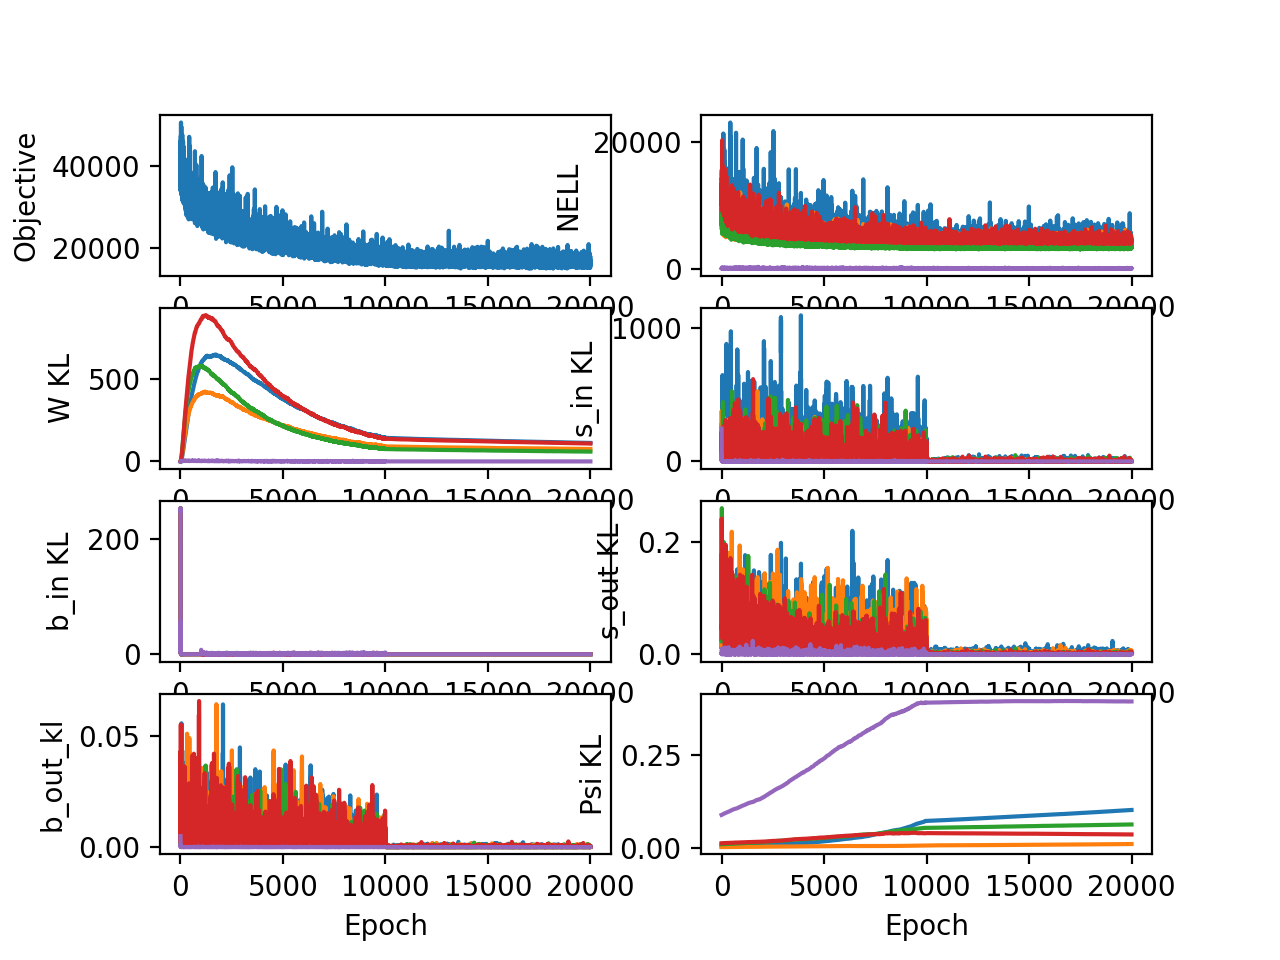

In [8]:
for log in fit_rs['logs']:
    Fitter.plot_log(log)

## Load segment tables, fold structures and data

Load segment tables

In [9]:
segment_table_path = pathlib.Path(fit_ps['segment_table_dir']) / fit_ps['segment_table_file']
with open(segment_table_path, 'rb') as f:
    st_data = pickle.load(f)
    segment_tables = st_data['segment_tables']
segment_tables = {k: SegmentTable.from_dict(v) for k, v in segment_tables.items()}

Load fold structures

In [10]:
fold_str_path = pathlib.Path(fit_ps['fold_str_dir']) / fit_ps['fold_str_file']
with open(fold_str_path, 'rb') as f:
    fold_groups = pickle.load(f)

Load the data

In [11]:
subject_data, subject_neuron_locs = load_and_preprocess_data(data_folder=fit_ps['data_dir'], 
                                            subjects=subject_order,
                                            normalize_beh_vars=fit_ps['normalize_beh_vars'],
                                            neural_gain=fit_ps['neural_gain'], 
                                            beh_gain=fit_ps['beh_gain'],
                                            z_ratio=fit_ps['z_ratio'])


Done loading data for subject subject_1.
Done loading data for subject subject_2.
Done loading data for subject subject_5.
Done loading data for subject subject_6.
Done loading data for subject subject_10.


Form the train, validation and test data 

In [12]:
data = dict()
for s_n in subject_order:
    subject_train_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['train'])
    train_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                          slices=subject_train_slices,
                                          ts_keys=['dff', 'behavior'], inc_time_stamps=True)
    
    train_data_n = (train_data_n.data[0][train_data_n.i_x, :], 
                    train_data_n.data[1][train_data_n.i_y, :],
                    train_data_n.data[2][train_data_n.i_y])

    
    
    subject_test_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['test'])
    test_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                         slices=subject_test_slices,
                                         ts_keys=['dff', 'behavior'], inc_time_stamps=True)
    
    test_data_n = (test_data_n.data[0][test_data_n.i_x, :], 
                   test_data_n.data[1][test_data_n.i_y, :],
                   test_data_n.data[2][test_data_n.i_y])
    
    subject_validation_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['validation'])
    validation_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                               slices=subject_validation_slices,
                                               ts_keys=['dff', 'behavior'], 
                                               inc_time_stamps=True)
    
    validation_data_n = (validation_data_n.data[0][validation_data_n.i_x, :], 
                         validation_data_n.data[1][validation_data_n.i_y, :],
                         validation_data_n.data[2][validation_data_n.i_y])
    
    data[s_n] = {'train': train_data_n, 
                 'test': test_data_n, 
                 'validation': validation_data_n}

## Perform retrospective early stopping to pick the best model

Load checkpoints

In [13]:
cp_dir = pathlib.Path(fit_ps[ps['mdl_type'] + '_cp_dir'])
cp_files = glob.glob(str(cp_dir / 'cp_*.pt'))
n_cps = len(cp_files)
cp_rs = [None]*n_cps
for cp_i, cp_file in enumerate(cp_files):
    cp_rs[cp_i] = torch.load(cp_file)
    print('Done loading check point ' + str(cp_i + 1) + ' of ' + str(n_cps) + '.')

Done loading check point 1 of 41.
Done loading check point 2 of 41.
Done loading check point 3 of 41.
Done loading check point 4 of 41.
Done loading check point 5 of 41.
Done loading check point 6 of 41.
Done loading check point 7 of 41.
Done loading check point 8 of 41.
Done loading check point 9 of 41.
Done loading check point 10 of 41.
Done loading check point 11 of 41.
Done loading check point 12 of 41.
Done loading check point 13 of 41.
Done loading check point 14 of 41.
Done loading check point 15 of 41.
Done loading check point 16 of 41.
Done loading check point 17 of 41.
Done loading check point 18 of 41.
Done loading check point 19 of 41.
Done loading check point 20 of 41.
Done loading check point 21 of 41.
Done loading check point 22 of 41.
Done loading check point 23 of 41.
Done loading check point 24 of 41.
Done loading check point 25 of 41.
Done loading check point 26 of 41.
Done loading check point 27 of 41.
Done loading check point 28 of 41.
Done loading check point 29 o

Evaluate performance at each check point

In [14]:
validation_subject_inds = [np.argwhere(np.asarray(subject_order) == s_n)[0][0] 
                               for s_n in ps['validation_subjects']]
n_validation_stopping_subjects = len(validation_subject_inds)

In [15]:
cp_performance = np.zeros([n_cps, n_validation_stopping_subjects])
for cp_i, cp in enumerate(cp_rs):
    for i, (s_i, s_n) in enumerate(zip(validation_subject_inds, ps['validation_subjects'])):
        x = data[s_n]['validation'][0]
        y = data[s_n]['validation'][1].numpy()
        coll = VICollection.from_checkpoint(cp['vi_collections'][s_i], props=subject_neuron_locs[s_n])
        y_hat = predict(coll, x).detach().numpy()
        cp_performance[cp_i, i]  = np.mean(r_squared(truth=y, pred=y_hat))

Sort checkpoints by epoch

In [16]:
cp_epochs = np.asarray([cp['total_epoch'] for cp in cp_rs])
cp_sort_order = np.argsort(cp_epochs)
cp_epochs = cp_epochs[cp_sort_order]
cp_rs = [cp_rs[i] for i in cp_sort_order]
cp_performance = cp_performance[cp_sort_order]

View performance across check points

<IPython.core.display.Javascript object>


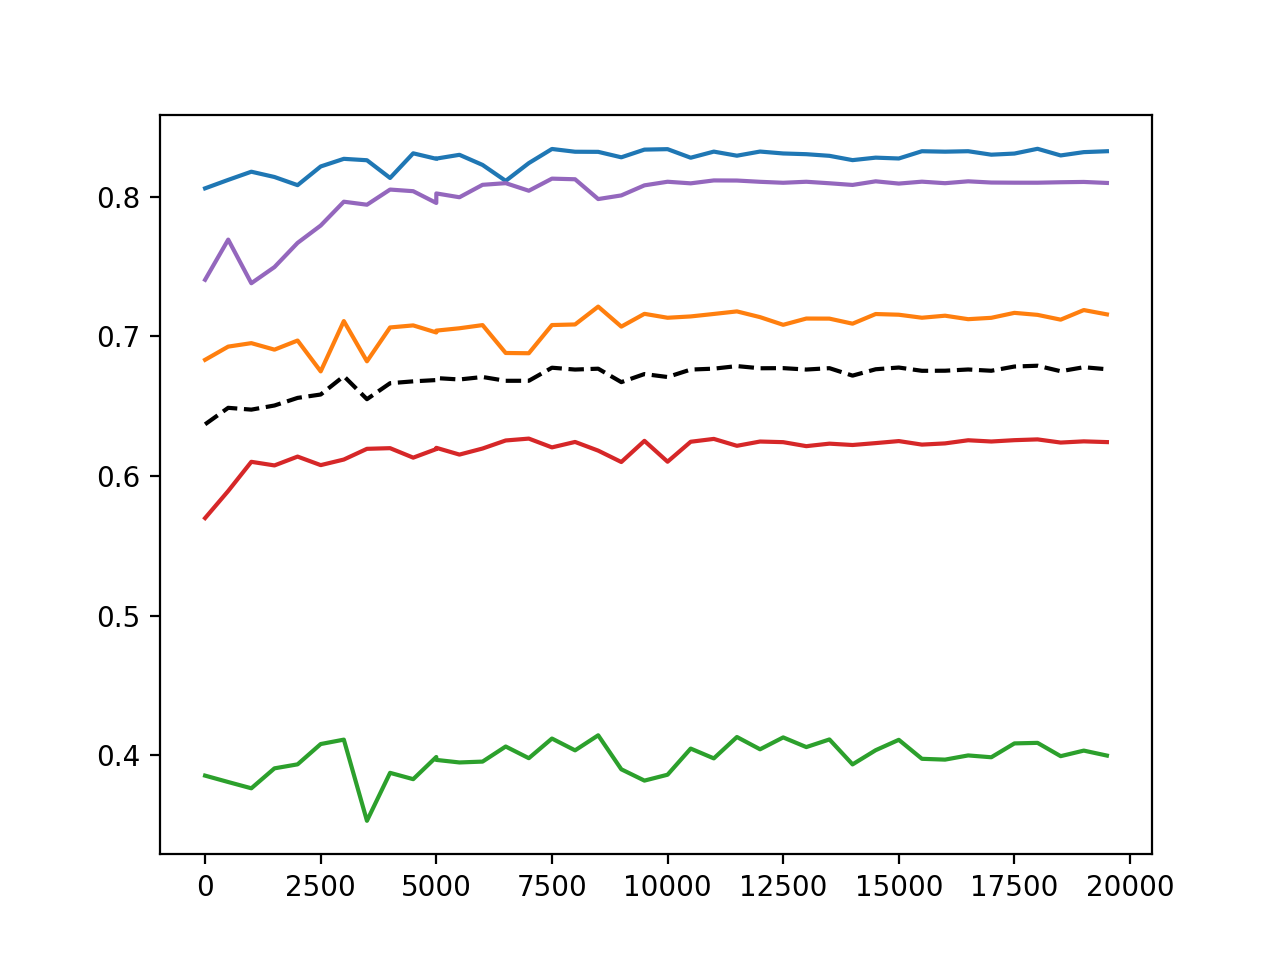

In [17]:
mean_cp_performance = np.mean(cp_performance, axis=1)

plt.figure()
plt.plot(cp_epochs, cp_performance)
plt.plot(cp_epochs, mean_cp_performance, 'k--')

Pick the best check point here

In [18]:
if ps['use_early_stopping']:
    best_cp_ind = np.argmax(mean_cp_performance)
    best_cp = cp_rs[best_cp_ind]
    
    best_vi_collections = [VICollection.from_checkpoint(best_cp['vi_collections'][s_i], 
                                                        props=subject_neuron_locs[s_n])
                           for s_i, s_n in enumerate(subject_order)]
    
    best_priors = PriorCollection.from_checkpoint(best_cp['priors'])
    
    print('Best CP epoch: ' + str(cp_epochs[best_cp_ind]))
else:
    best_vi_collections = fit_rs['vi_collections']
    best_priors = fit_rs['priors']

Best CP epoch: 18000


## View predictions for the best performing models

In [19]:
ex_s_n = ps['validation_subjects'][0]
vis_data = 'validation'

In [20]:
ex_s_i = np.argwhere(np.asarray(subject_order) == ex_s_n)[0][0]

In [21]:
t = data[subject_order[ex_s_i]][vis_data][2].numpy()
x = data[subject_order[ex_s_i]][vis_data][0]
y = data[subject_order[ex_s_i]][vis_data][1]
y_hat = predict(best_vi_collections[ex_s_i], x).detach()

In [22]:
r_squared(y.numpy(), y_hat.numpy())

array([0.80678874, 0.86205655], dtype=float32)

<IPython.core.display.Javascript object>


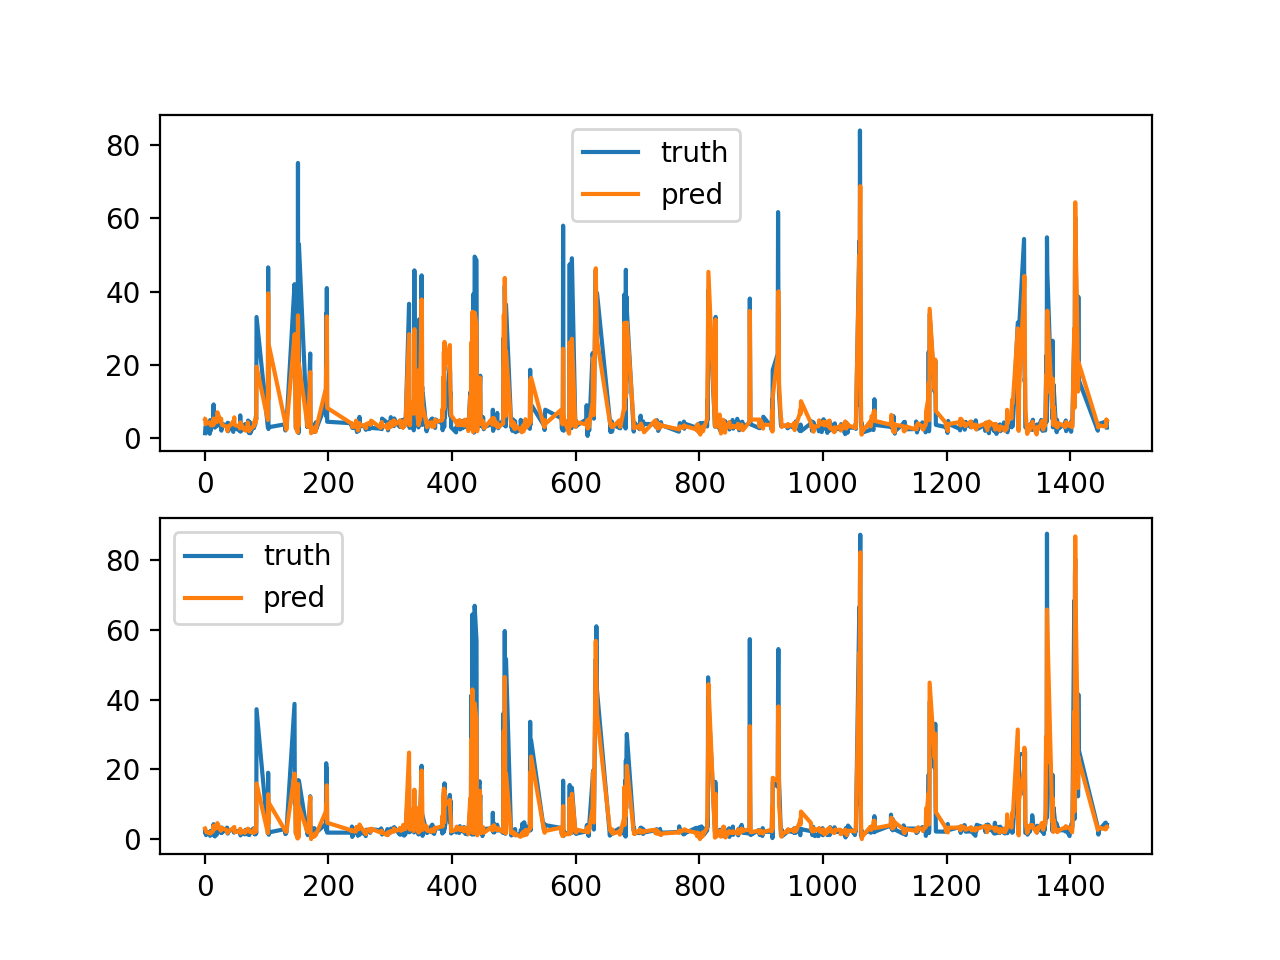

In [23]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, y[:,0])
plt.plot(t, y_hat[:,0])
plt.legend(['truth', 'pred'])

plt.subplot(2,1,2)
plt.plot(t, y[:,1])
plt.plot(t, y_hat[:,1])
plt.legend(['truth', 'pred'])


## Debug code goes here

In [30]:
best_priors.w_prior.dists[0].mn_f()

SumOfTiledHyperCubeBasisFcns()

In [24]:
for s_i, s_n in enumerate(subject_order):
    print('Subject: ' + str(s_n))
    
    s_in_mn = best_vi_collections[s_i].posteriors.s_in_post(torch.zeros(1)).detach().numpy().squeeze()
    s_in_std = best_vi_collections[s_i].posteriors.s_in_post.dists[0].std_f(torch.zeros(1)).detach().numpy().squeeze()
    print('S_in Mean: ' + str(s_in_mn))
    print('S_in Std: ' + str(s_in_std))
    
    b_in_mn = best_vi_collections[s_i].posteriors.b_in_post(torch.zeros(1)).detach().numpy().squeeze()
    b_in_std = best_vi_collections[s_i].posteriors.b_in_post.dists[0].std_f(torch.zeros(1)).detach().numpy().squeeze()
    print('B_in Mean: ' + str(b_in_mn))
    print('B_in Std: ' + str(b_in_std))
    
    s_out_mn = best_vi_collections[s_i].posteriors.s_out_post(torch.zeros(1)).detach().numpy().squeeze()
    s_out_std = best_vi_collections[s_i].posteriors.s_out_post.dists[0].std_f(torch.zeros(1)).detach().numpy().squeeze()
    print('S_out Mean: ' + str(s_out_mn))
    print('S_out Std: ' + str(s_out_std))
    
    
    
    b_out_mn = best_vi_collections[s_i].posteriors.b_out_post(torch.zeros(1)).detach().numpy().squeeze()
    b_out_std = best_vi_collections[s_i].posteriors.b_out_post.dists[0].std_f(torch.zeros(1)).detach().numpy().squeeze()
    print('B_out Mean: ' + str(b_out_mn))
    print('B_out Std: ' + str(b_out_std))

Subject: 1
S_in Mean: [0.00100063 0.00099865 0.00099909 0.00100059 0.00099946 0.0009978
 0.00099935 0.00100042 0.0009981  0.00099972]
S_in Std: [1.0019120e-06 1.0033908e-06 1.0008953e-06 9.9904673e-07 1.0009262e-06
 9.9802548e-07 9.9471924e-07 1.0018013e-06 9.9690874e-07 1.0105751e-06]
B_in Mean: [ 6.8217036e-09 -8.8804537e-09  1.7209987e-09 -7.2341515e-09
 -3.5948418e-08  8.3344860e-09  3.3371002e-09 -9.5004111e-09
 -3.9846162e-09  2.7349811e-08]
B_in Std: [9.9999966e-07 1.0000107e-06 9.9999886e-07 1.0000074e-06 1.0000057e-06
 1.0000051e-06 9.9999102e-07 1.0000009e-06 1.0000015e-06 1.0000011e-06]
S_out Mean: [1.0000026  0.99999326]
S_out Std: [0.00010039 0.00010039]
B_out Mean: [ 6.4618462e-08 -1.8459104e-06]
B_out Std: [0.00010006 0.0001    ]
Subject: 2
S_in Mean: [0.00099998 0.00099905 0.00100015 0.00100004 0.00100044 0.00100001
 0.00100018 0.00100015 0.00100014 0.00100014]
S_in Std: [9.9738475e-07 9.9729846e-07 9.9827582e-07 9.9844021e-07 1.0032130e-06
 1.0039768e-06 9.8714452e-07 

In [25]:
best_priors.s_out_prior.dists[0].mn_f(torch.zeros(1))

tensor([[1.],
        [1.]])